In [18]:
import pandas as pd
import numpy as np
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [8]:
# Cargar los datos
df = pd.read_csv('../../../data/df_final.csv',index_col='date', parse_dates=True)


# EURUSD

In [10]:
# Definir la variable objetivo
target = 'eurusd_trend'
# lista con las variables del periodo presente t
t = ['eurusd', 'jpyusd', 'gbpusd', 'nq', 'sp500', 'nikkei', 'ftse', 'gdp_us',
       'gdp_uk', 'gdp_jp', 'gdp_ez', 'unrate_us', 'unrate_uk', 'unrate_jp',
       'unrate_ez', 'm0_us', 'm0_jp', 'm0_ez', 'ir_us', 'ir_uk', 'ir_ez',
       'ir_jp', 'eurusd_pct_change', 'jpyusd_pct_change', 'gbpusd_pct_change',
       'eurusd_trend', 'jpyusd_trend', 'gbpusd_trend']

# Separar características (X) y objetivo (y)
X = df.drop(columns=t, axis=1)
y = df[target]


In [11]:
# Escalar los datos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [12]:
# Dividir los datos en conjuntos de entrenamiento y prueba respetando la secuencia temporal
test_size = 0.2
n_test = int(len(df) * test_size)
X_train, X_test = X_scaled[:-n_test], X_scaled[-n_test:]
y_train, y_test = y[:-n_test], y[-n_test:]

# Convertir a formato adecuado para LSTM [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [13]:
def create_model(trial):
    model = Sequential()
    model.add(LSTM(trial.suggest_int('units', 10, 100), input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
    model.add(Dropout(trial.suggest_float('dropout', 0.2, 0.5)))
    model.add(LSTM(trial.suggest_int('units2', 10, 100)))
    model.add(Dropout(trial.suggest_float('dropout2', 0.2, 0.5)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=Adam(learning_rate=trial.suggest_float('learning_rate', 1e-5, 1e-2)),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

def objective(trial):
    model = create_model(trial)
    model.fit(X_train, y_train, epochs=10, batch_size=trial.suggest_int('batch_size', 16, 128), verbose=0)
    score = model.evaluate(X_test, y_test, verbose=0)
    return score[0]  # Minimizamos la pérdida (loss)


In [14]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Mejor hiperparámetro encontrado
print('Best hyperparameters: ', study.best_params)


[I 2024-06-24 19:59:50,191] A new study created in memory with name: no-name-7b1f8461-85ab-4391-82e4-bb10887ae22a
c:\Users\usuario\anaconda3\envs\TFM\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2024-06-24 19:59:53,581] Trial 0 finished with value: 0.695122241973877 and parameters: {'units': 69, 'dropout': 0.45575987276923025, 'units2': 34, 'dropout2': 0.2801010291437915, 'learning_rate': 0.0006786450324937211, 'batch_size': 107}. Best is trial 0 with value: 0.695122241973877.
[I 2024-06-24 19:59:57,341] Trial 1 finished with value: 0.6949452757835388 and parameters: {'units': 70, 'dropout': 0.4180174188407426, 'units2': 27, 'dropout2': 0.26556855377524013, 'learning_rate': 0.00523239127482128, 'batch_size': 31}. Best is trial 1 with value: 0.6949452757835388.
[I 2024

Best hyperparameters:  {'units': 70, 'dropout': 0.4180174188407426, 'units2': 27, 'dropout2': 0.26556855377524013, 'learning_rate': 0.00523239127482128, 'batch_size': 31}


In [15]:
best_params = study.best_params

model = Sequential()
model.add(LSTM(best_params['units'], input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(best_params['dropout']))
model.add(LSTM(best_params['units2']))
model.add(Dropout(best_params['dropout2']))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=50, batch_size=best_params['batch_size'], verbose=1)


Epoch 1/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4874 - loss: 0.6972
Epoch 2/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5243 - loss: 0.6919
Epoch 3/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5295 - loss: 0.6898
Epoch 4/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5423 - loss: 0.6853
Epoch 5/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5650 - loss: 0.6828
Epoch 6/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5576 - loss: 0.6797
Epoch 7/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5596 - loss: 0.6766
Epoch 8/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5789 - loss: 0.6725
Epoch 9/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5899 - loss: 0.6658
Epoch 10/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5836 - loss: 0.6595
Epoch 11/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5930 - loss: 0.6508
Epoch 12/50
128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 698us/step


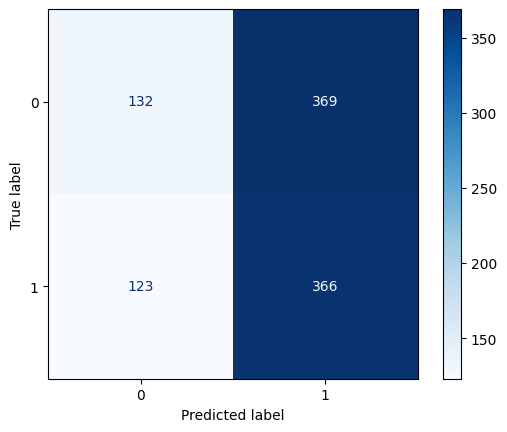

              precision    recall  f1-score    support
0              0.517647  0.263473  0.349206  501.00000
1              0.497959  0.748466  0.598039  489.00000
accuracy       0.503030  0.503030  0.503030    0.50303
macro avg      0.507803  0.505970  0.473623  990.00000
weighted avg   0.507922  0.503030  0.472115  990.00000


In [19]:
# Hacer predicciones
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Calcular la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Calcular y mostrar las métricas del modelo
report = classification_report(y_test, y_pred, target_names=['0', '1'], output_dict=True)
metrics_df = pd.DataFrame(report).transpose()
print(metrics_df)
